In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.metrics import RootMeanSquaredError,R2Score, MeanAbsoluteError
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [2]:
df = pd.read_csv('clean.csv',parse_dates=['datetime'])
df.drop(columns = ['Unnamed: 0'], inplace =True)
train_set_dates = df.copy()

In [8]:
# Normalizing the data

datetime_col = df['datetime']
feature_cols = df.drop(columns=['datetime'])

scaler = MinMaxScaler()

normalized_values = scaler.fit_transform(feature_cols)

df_normalized = pd.DataFrame(normalized_values, columns=feature_cols.columns)

df_normalized.head()


CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)   NOx(GT)  PT08.S3(NOx)  \
0  0.211864     0.511845  0.185535       0.362097  0.111036      0.310885   
1  0.161017     0.463029  0.146226       0.312398  0.068382      0.360864   
2  0.177966     0.541996  0.139937       0.303659  0.087339      0.346463   
3  0.177966     0.523331  0.143082       0.308575  0.115098      0.326133   
4  0.127119     0.448672  0.100629       0.247406  0.087339      0.373994   

    NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)         T        RH        AH  
0  0.328402      0.513040     0.454822  0.333333  0.499371  0.280066  
1  0.266272      0.453237     0.326238  0.326882  0.484277  0.264282  
2  0.331361      0.451439     0.370547  0.296774  0.563522  0.276352  
3  0.355030      0.464478     0.426586  0.277419  0.638994  0.294190  
4  0.337278      0.422212     0.386186  0.281720  0.633962  0.295216

In [11]:

# Splitting the data in training and testing while maintaining the sequence.

train_ratio = 0.8

train_size = int(len(df_normalized) * train_ratio)

train_set = df_normalized.iloc[:train_size]
test_set = df_normalized.iloc[train_size:]


In [12]:
# Data Prepration:
# Function to create sequences of past observations
def create_sequences_multivariate(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback, :])
        y.append(data[i + lookback, :])  
    return np.array(X), np.array(y)



train_features = train_set.values
test_features = test_set.values

# Create training and testing sequences
lookback_window = 24
X_train, y_train = create_sequences_multivariate(train_features, lookback_window)
X_test, y_test = create_sequences_multivariate(test_features, lookback_window)

# Display the shapes of the training and testing datasets to verify (Samples in the df, lookback window, no. of features)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((7461, 24, 12), (7461, 12), (1848, 24, 12), (1848, 12))

In [14]:
# Simple RNN
model = Sequential([
    SimpleRNN(128, activation='relu', input_shape=(24, 12)),  
    Dense(64, activation='relu'),  
    Dense(12)  
])

# Compile the model
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001)  , loss='mse', metrics=[RootMeanSquaredError(),R2Score(),MeanAbsoluteError()])

# Train the model
history_rnn = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/5


C:\Users\kvats\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0479 - mean_absolute_error: 0.1596 - r2_score: -1.1947 - root_mean_squared_error: 0.2116
Epoch 2/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0078 - mean_absolute_error: 0.0664 - r2_score: 0.5920 - root_mean_squared_error: 0.0880
Epoch 3/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055 - mean_absolute_error: 0.0552 - r2_score: 0.7004 - root_mean_squared_error: 0.0744
Epoch 4/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0048 - mean_absolute_error: 0.0509 - r2_score: 0.7378 - root_mean_squared_error: 0.0693
Epoch 5/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0042 - mean_absolute_error: 0.0478 - r2_score: 0.7623 - root_mean_squared_error: 0.0652


In [15]:
#RNN predictions
# Evaluate the model on the test set
test_loss_rnn = model.evaluate(X_test, y_test, verbose=1)
predictions_rnn = model.predict(X_test)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - mean_absolute_error: 0.0531 - r2_score: 0.7219 - root_mean_squared_error: 0.0736
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [16]:
# GRU
model2 = Sequential([
    GRU(128, activation='relu', input_shape=(24, 12)),
    Dense(64, activation='relu'),
    Dense(12)  
])

# Compile the model
model2.compile(optimizer=  tf.keras.optimizers.Adam(learning_rate=0.01) , loss='mse', metrics=[RootMeanSquaredError(),R2Score(),MeanAbsoluteError()])


# Train the model
history_gru = model2.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)

Epoch 1/20


C:\Users\kvats\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0122 - mean_absolute_error: 0.0756 - r2_score: 0.3871 - root_mean_squared_error: 0.1057
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0039 - mean_absolute_error: 0.0451 - r2_score: 0.7867 - root_mean_squared_error: 0.0625
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0036 - mean_absolute_error: 0.0441 - r2_score: 0.7996 - root_mean_squared_error: 0.0602
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0037 - mean_absolute_error: 0.0444 - r2_score: 0.7999 - root_mean_squared_error: 0.0604
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0035 - mean_absolute_error: 0.0434 - r2_score: 0.8119 - root_mean_squared_error: 0.0589
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0035 - mean_absolute_error: 0.0428 - r2_score: 0.8088 - root_mean_squared_error: 0.0590
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0033 - mean_absolute_error: 0.0421 - r2_score: 0.

In [82]:
#GRU predictions
# Evaluate the model on the test set
test_loss_gru = model2.evaluate(X_test, y_test, verbose=1)
predictions_gru = model2.predict(X_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - mean_absolute_error: 0.0419 - r2_score: 0.8116 - root_mean_squared_error: 0.0599
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [19]:
#LSTM
model3 = Sequential([
    LSTM(128, activation='relu', input_shape=(24, 12)),
    Dense(64, activation='relu'),
    Dense(12)  
])

# Compile the model
model3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=[RootMeanSquaredError(),R2Score(),MeanAbsoluteError()])

# Train the model
history_lstm = model3.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)




Epoch 1/20


C:\Users\kvats\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0277 - mean_absolute_error: 0.1150 - r2_score: -0.2901 - root_mean_squared_error: 0.1581
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0051 - mean_absolute_error: 0.0524 - r2_score: 0.7331 - root_mean_squared_error: 0.0711
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0041 - mean_absolute_error: 0.0469 - r2_score: 0.7690 - root_mean_squared_error: 0.0642
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0036 - mean_absolute_error: 0.0432 - r2_score: 0.8022 - root_mean_squared_error: 0.0597
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0034 - mean_absolute_error: 0.0422 - r2_score: 0.8103 - root_mean_squared_error: 0.0584
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0033 - mean_absolute_error: 0.0408 - r2_score: 0.8231 - root_mean_squared_error: 0.0571
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0032 - mean_absolute_error: 0.0406 - r2_score: 0

In [20]:
#LSTM predictions
# Evaluate the model on the test set
test_loss_lstm = model3.evaluate(X_test, y_test, verbose=1)
predictions_lstm = model3.predict(X_test)



58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0036 - mean_absolute_error: 0.0412 - r2_score: 0.8135 - root_mean_squared_error: 0.0597
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


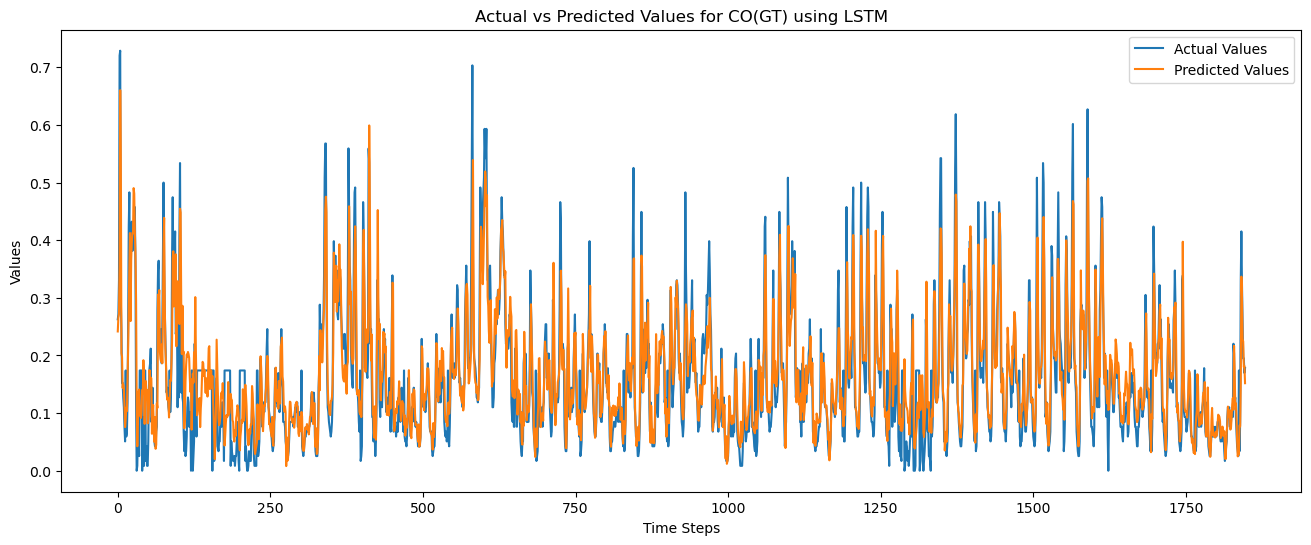

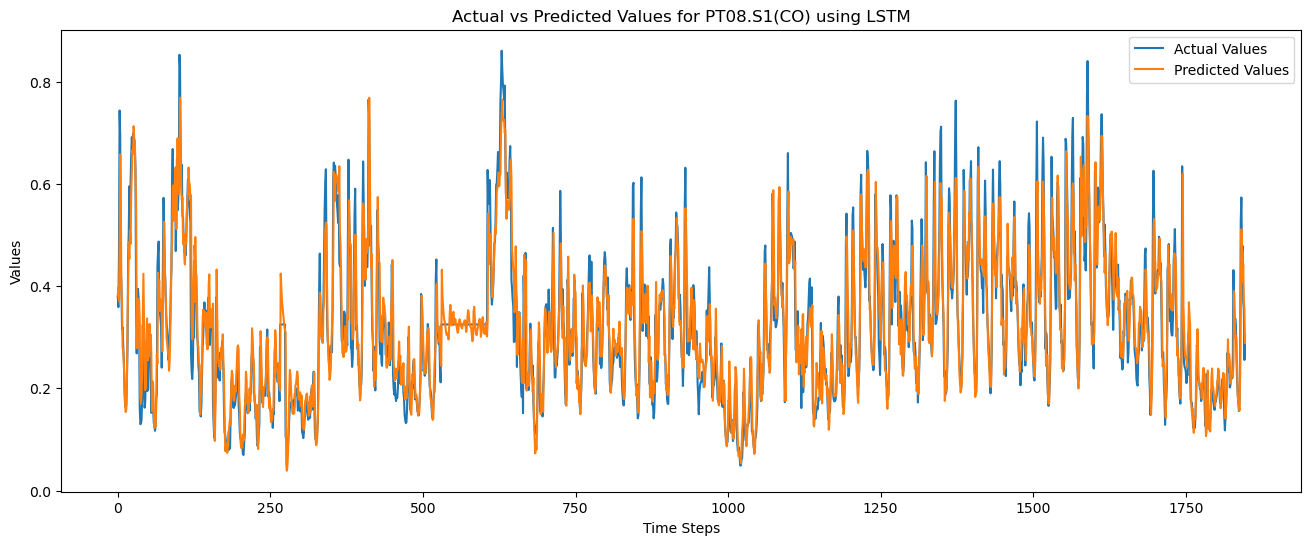

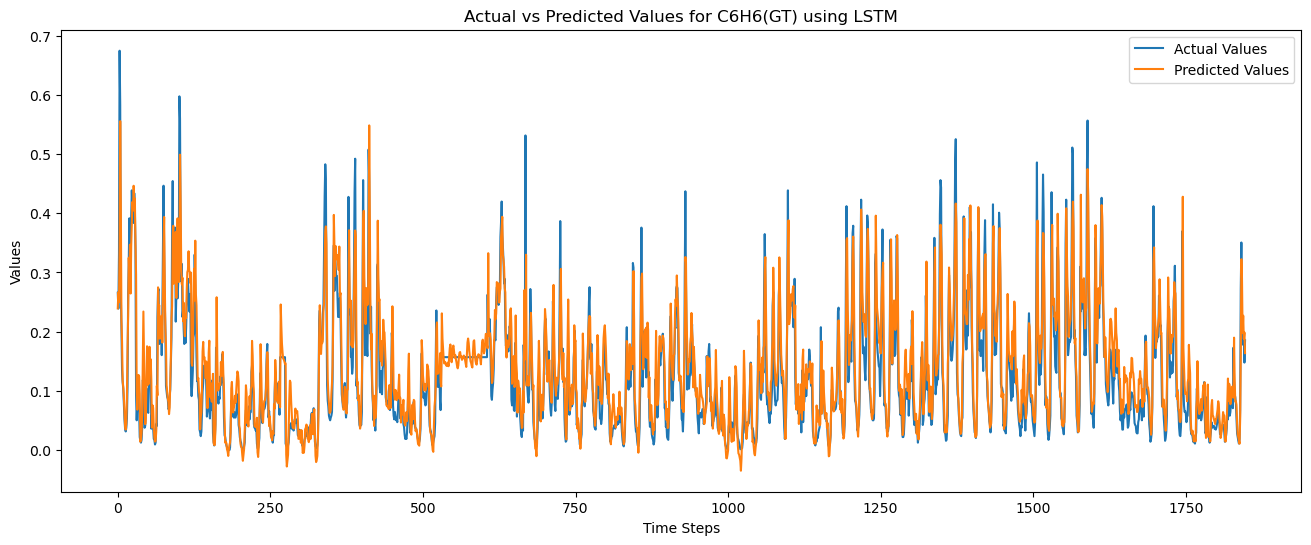

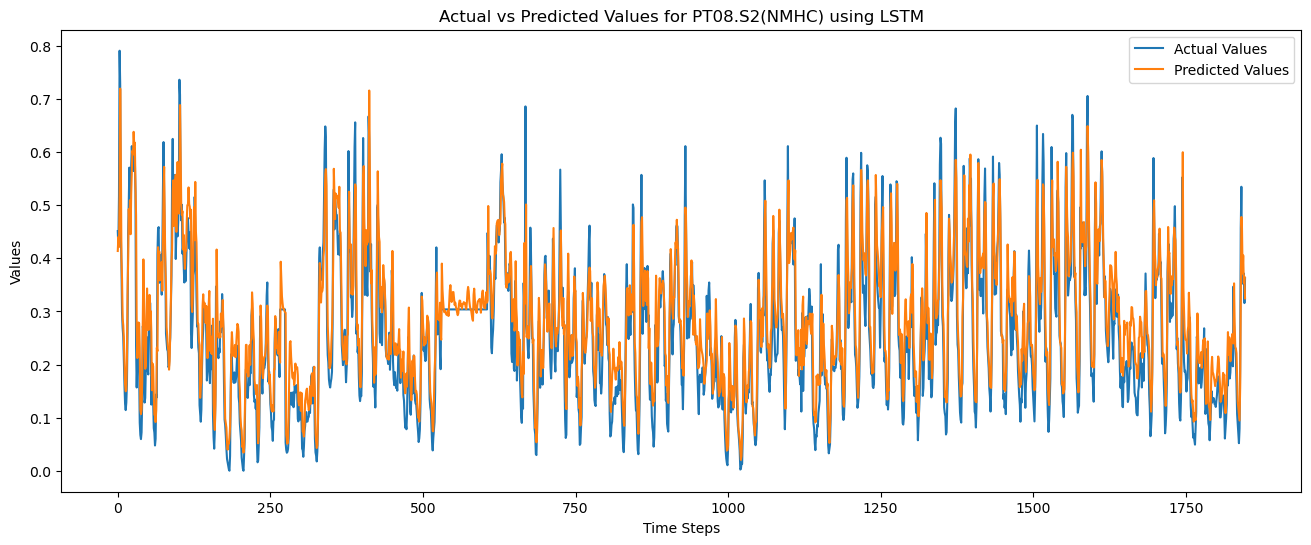

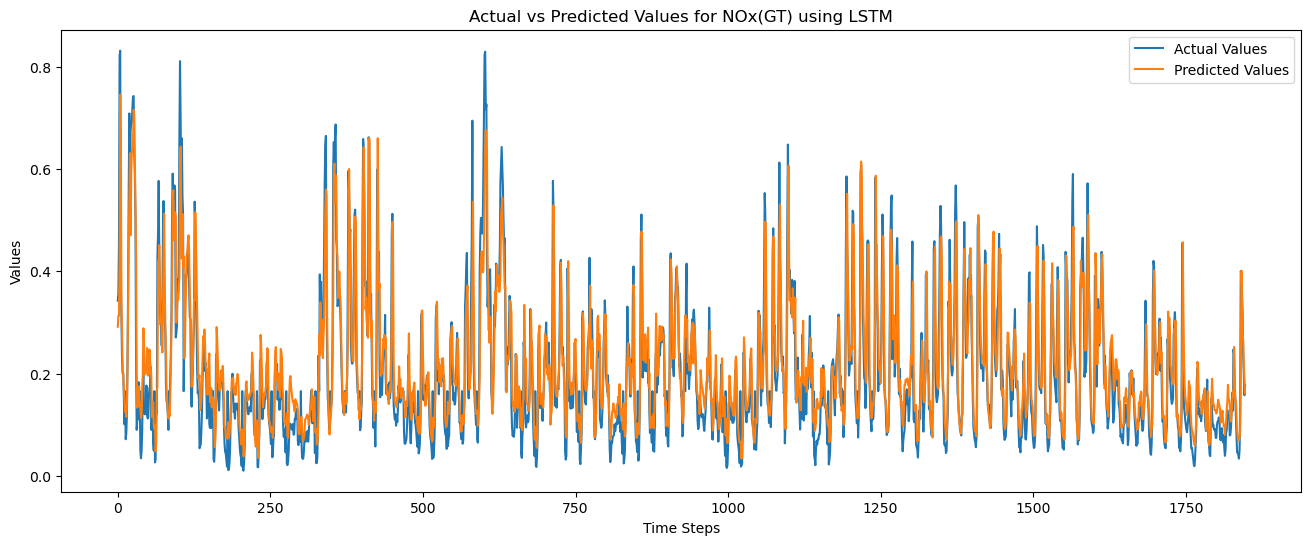

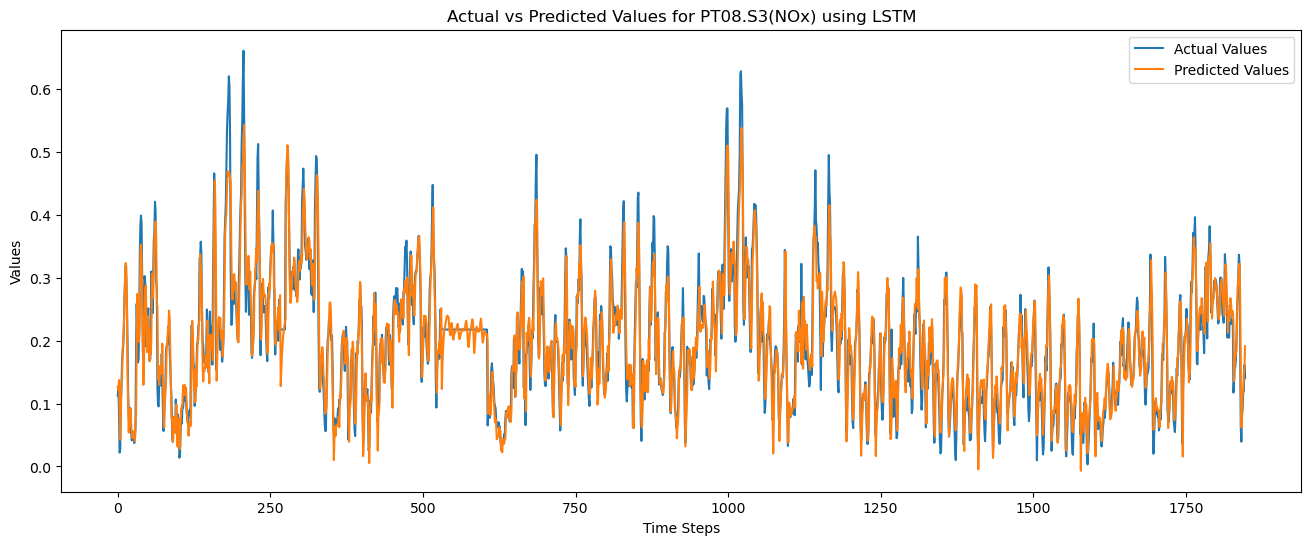

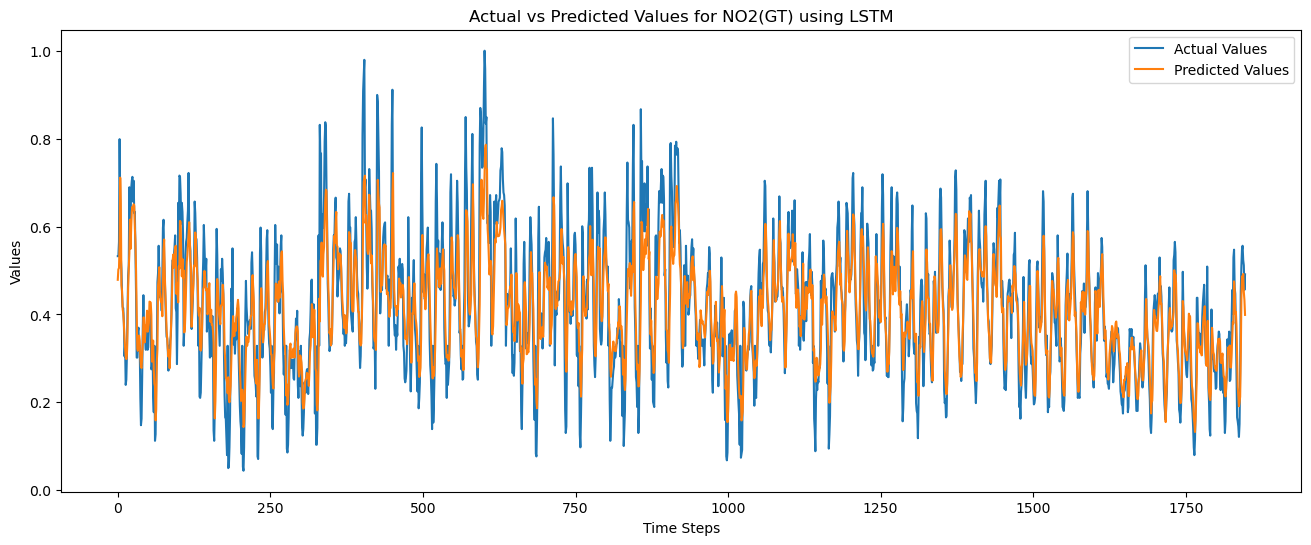

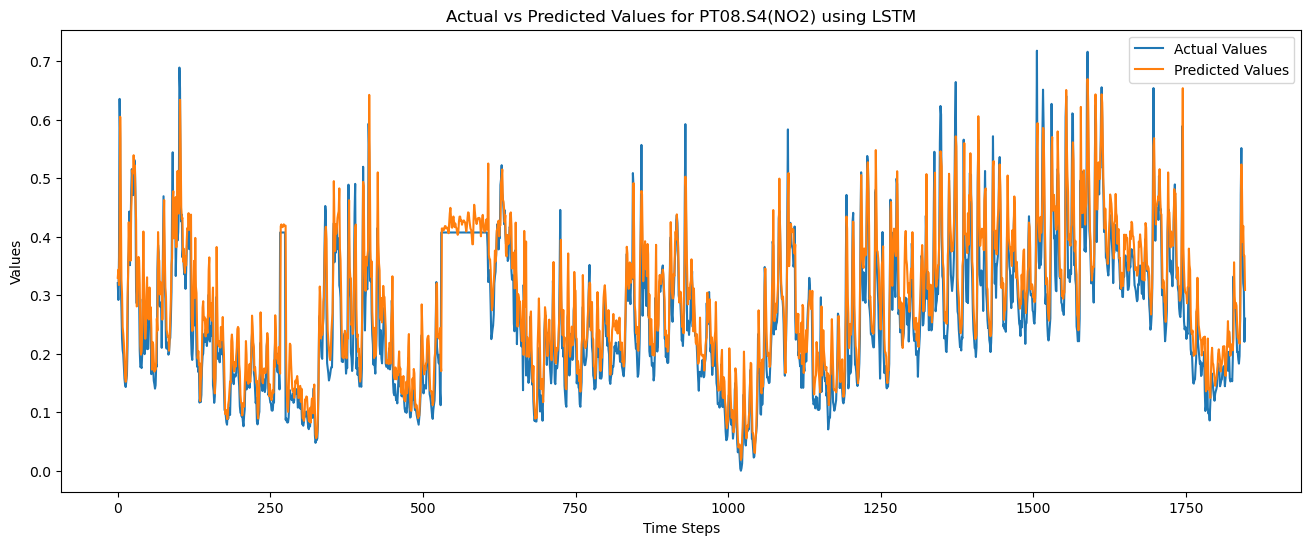

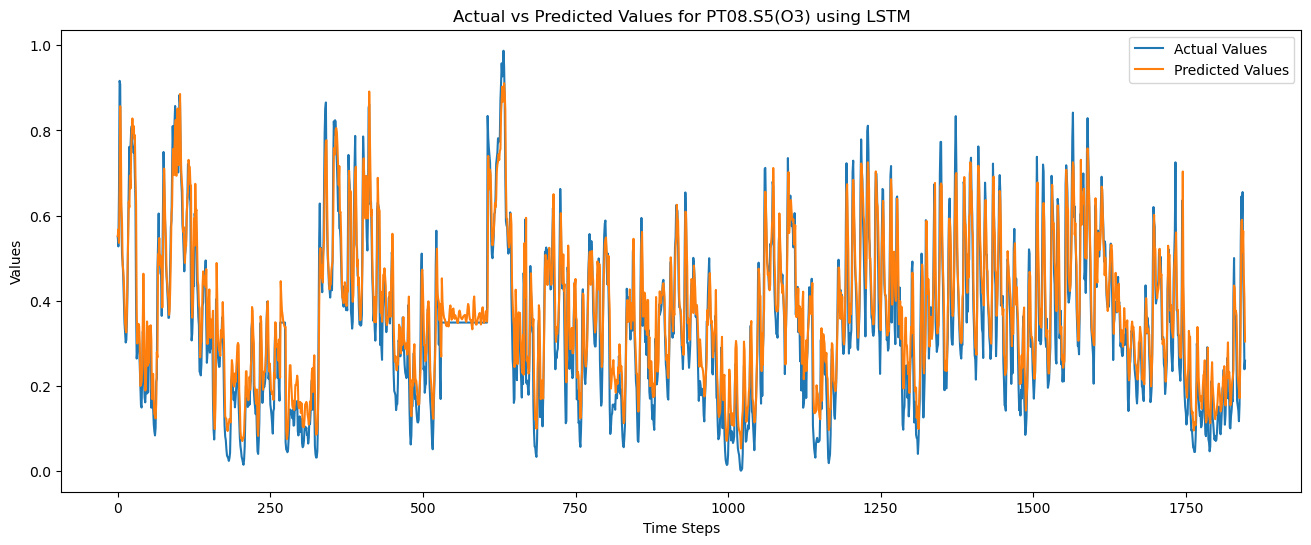

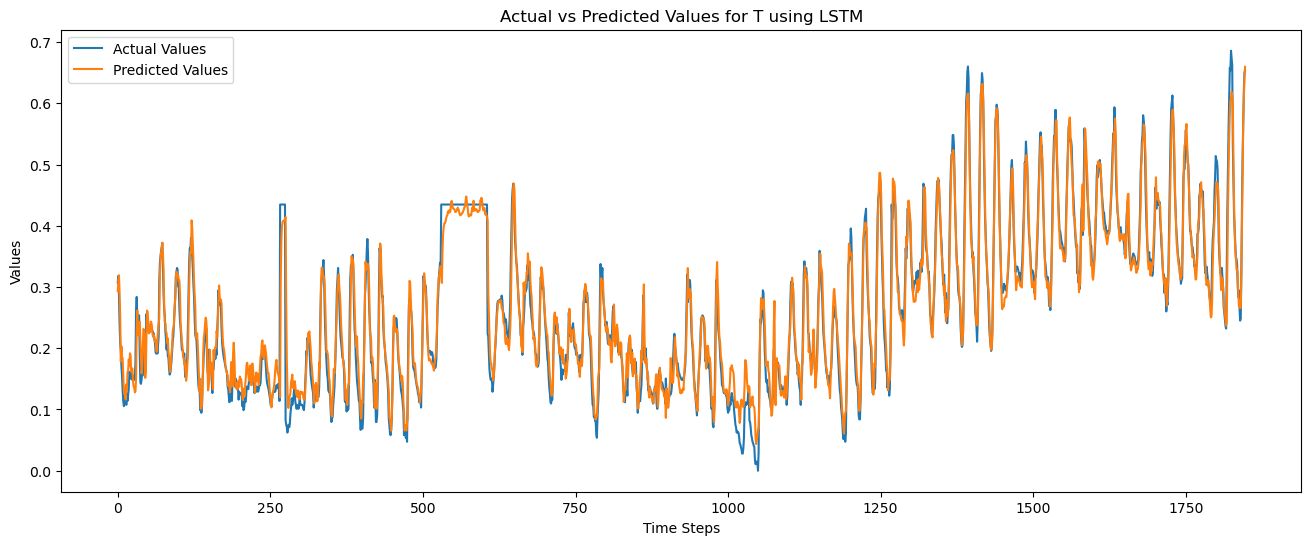

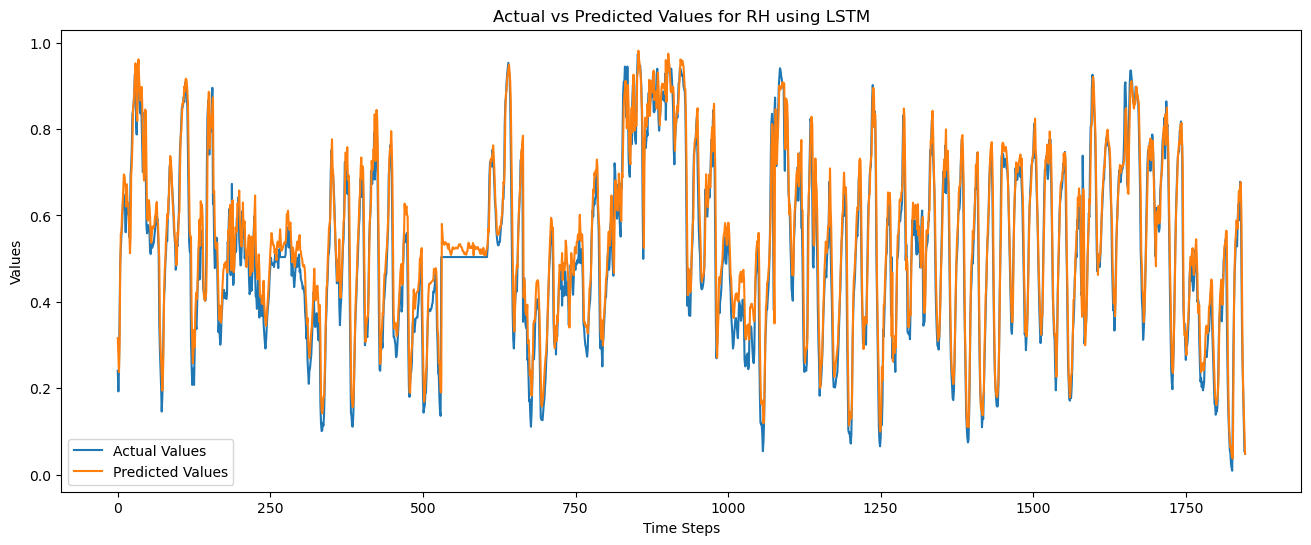

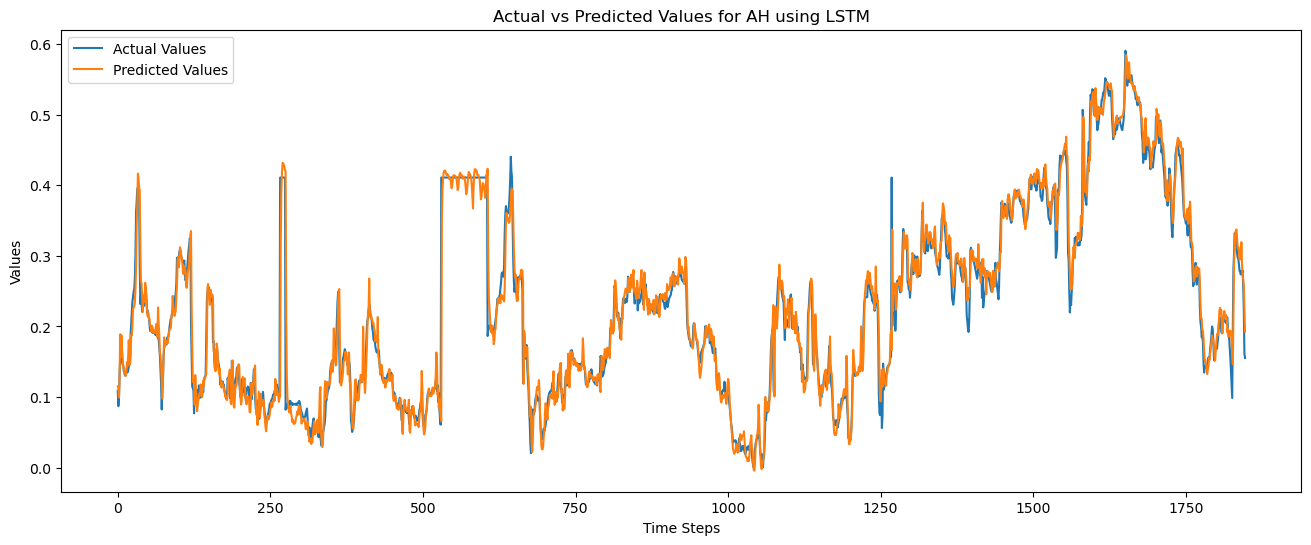

In [70]:
# Plot the predicted vs actual values for LSTM
for i in range(12):
    feature_index = i  # Change this index to select a different feature
    plt.figure(figsize=(16, 6))
    plt.plot(y_test[:, feature_index], label='Actual Values')
    plt.plot(predictions_lstm[:, feature_index], label='Predicted Values')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.title(f'Actual vs Predicted Values for {train_set.columns[feature_index + 1]} using LSTM')
    plt.legend()
    plt.show()

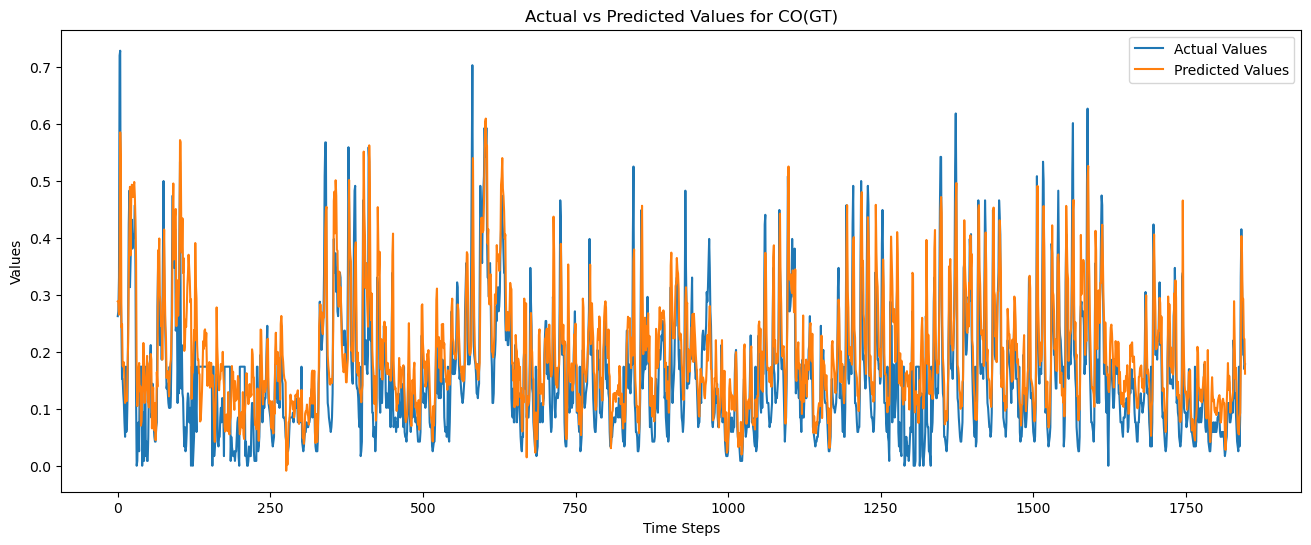

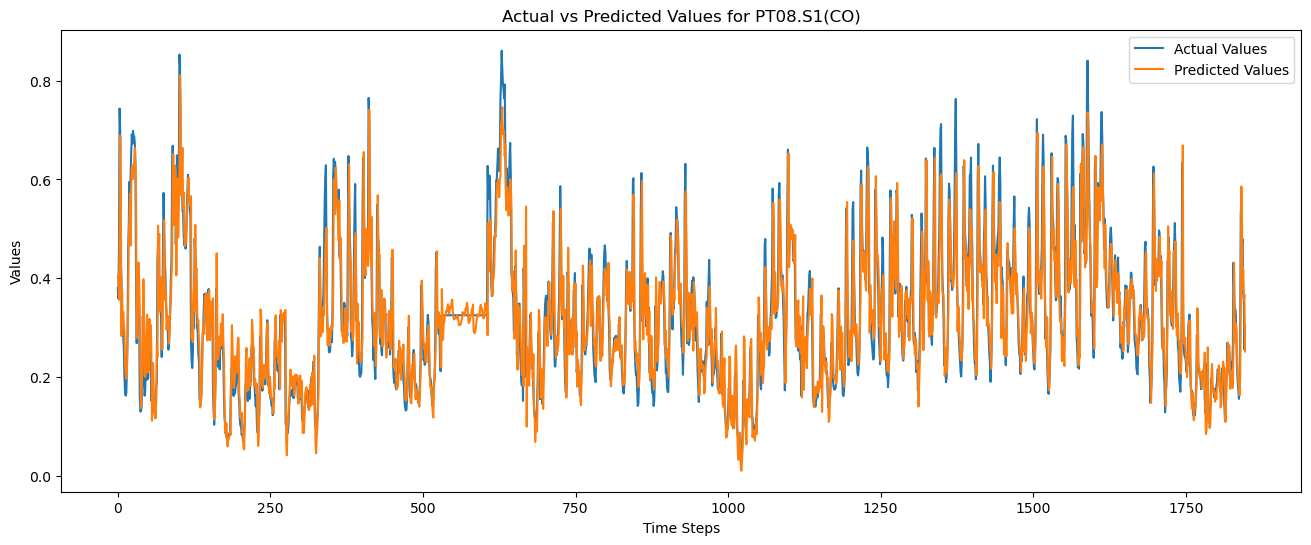

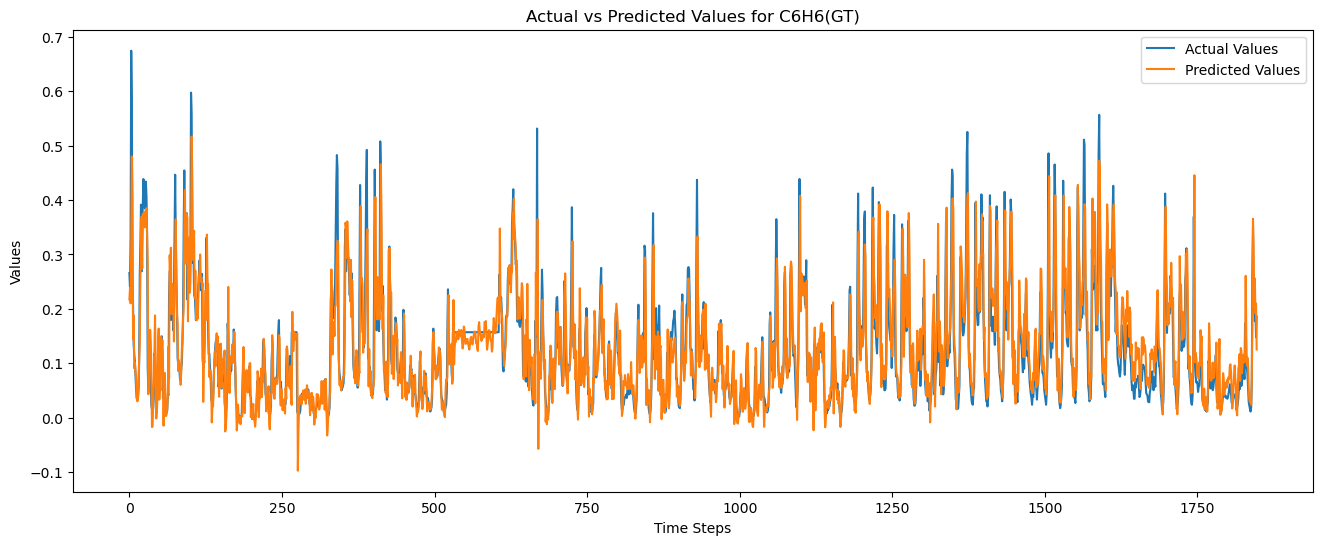

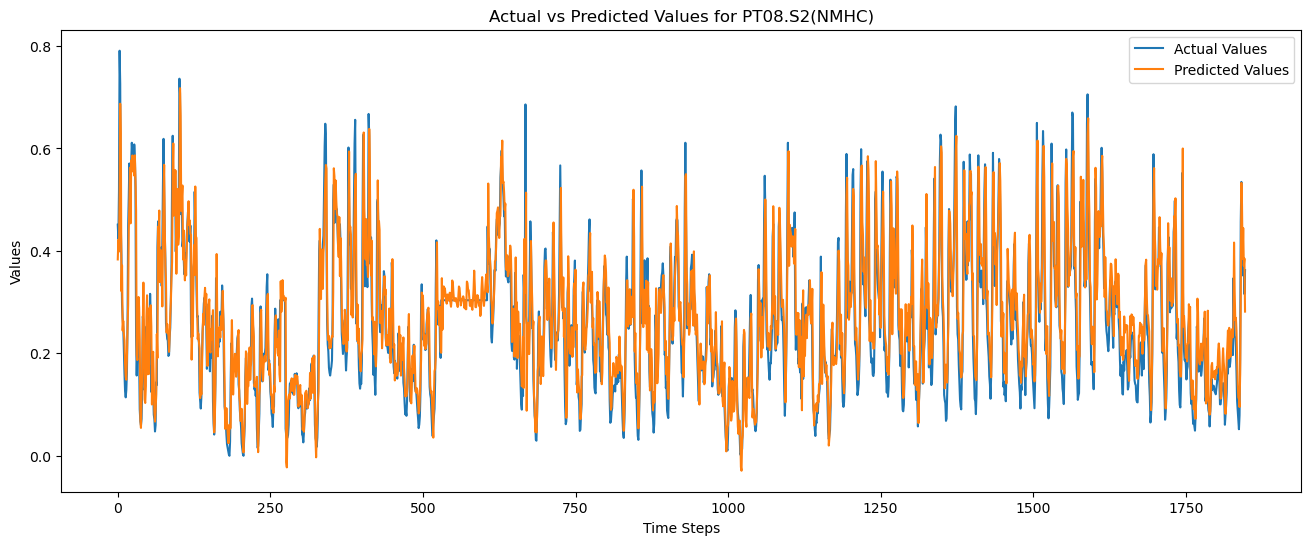

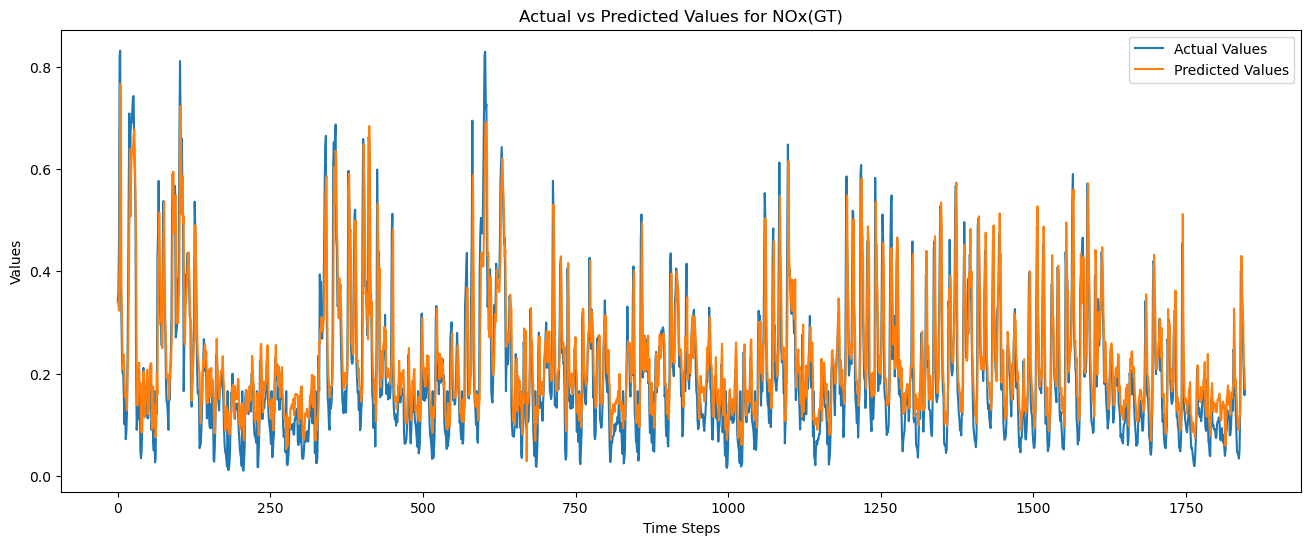

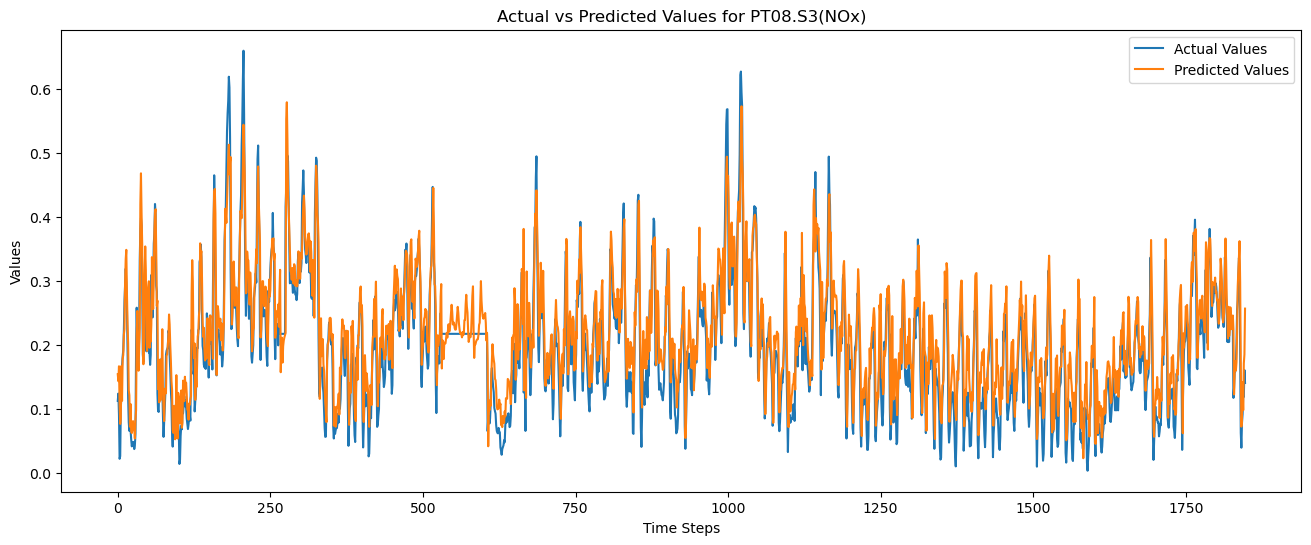

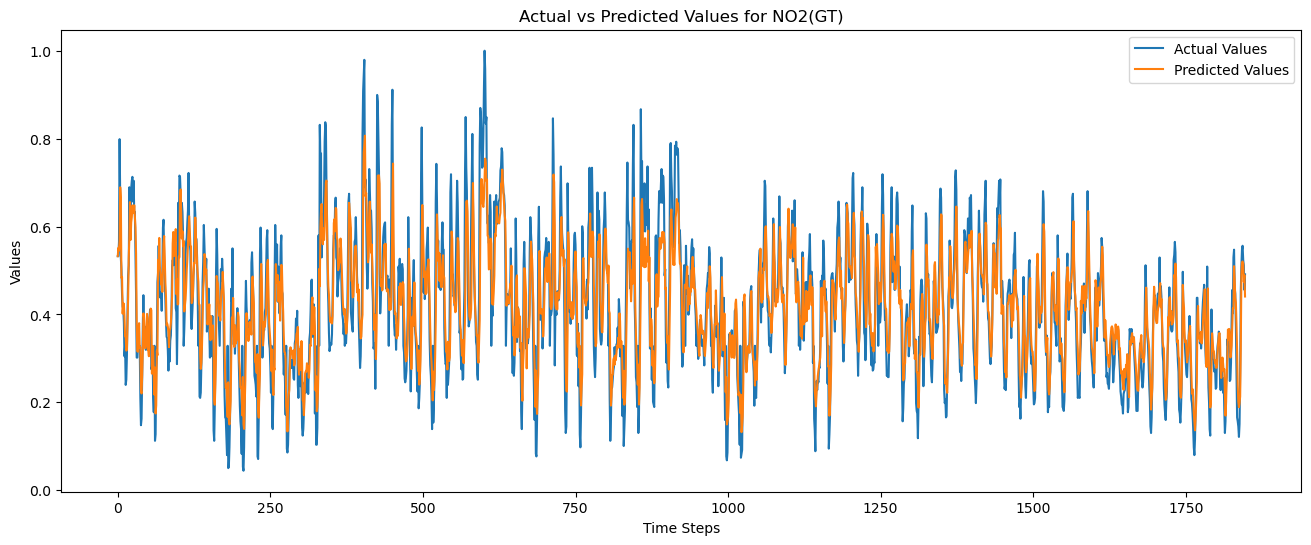

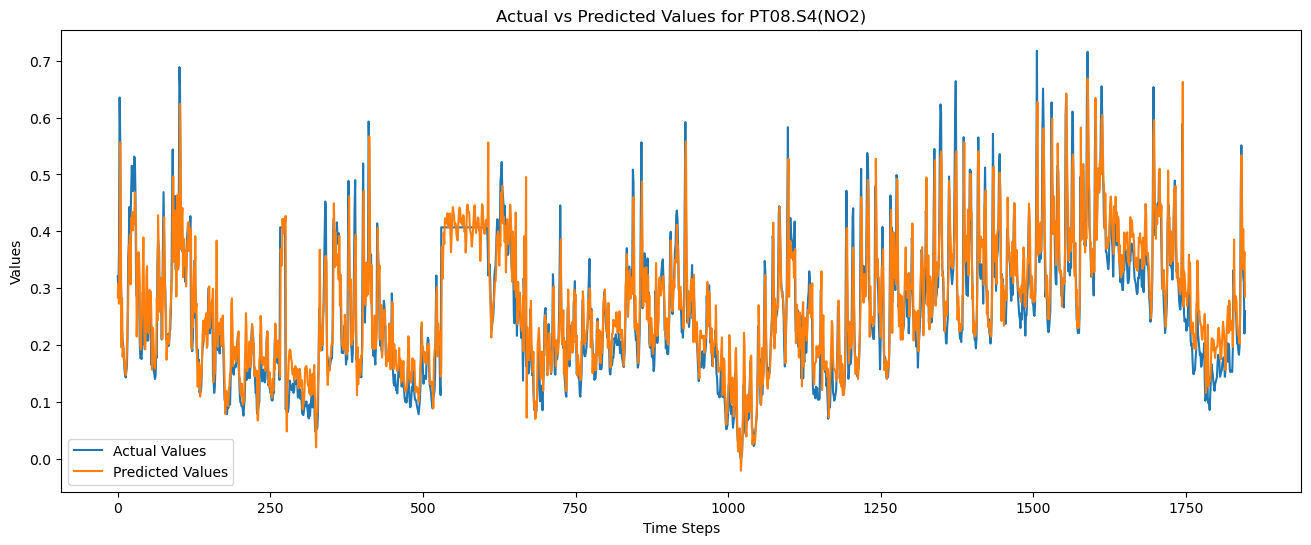

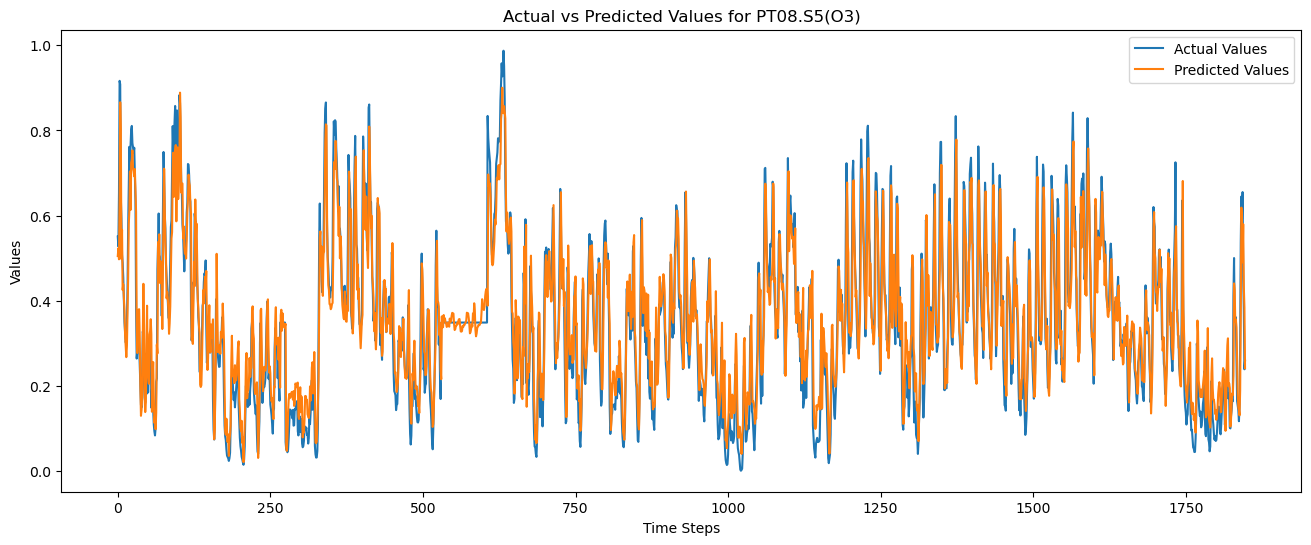

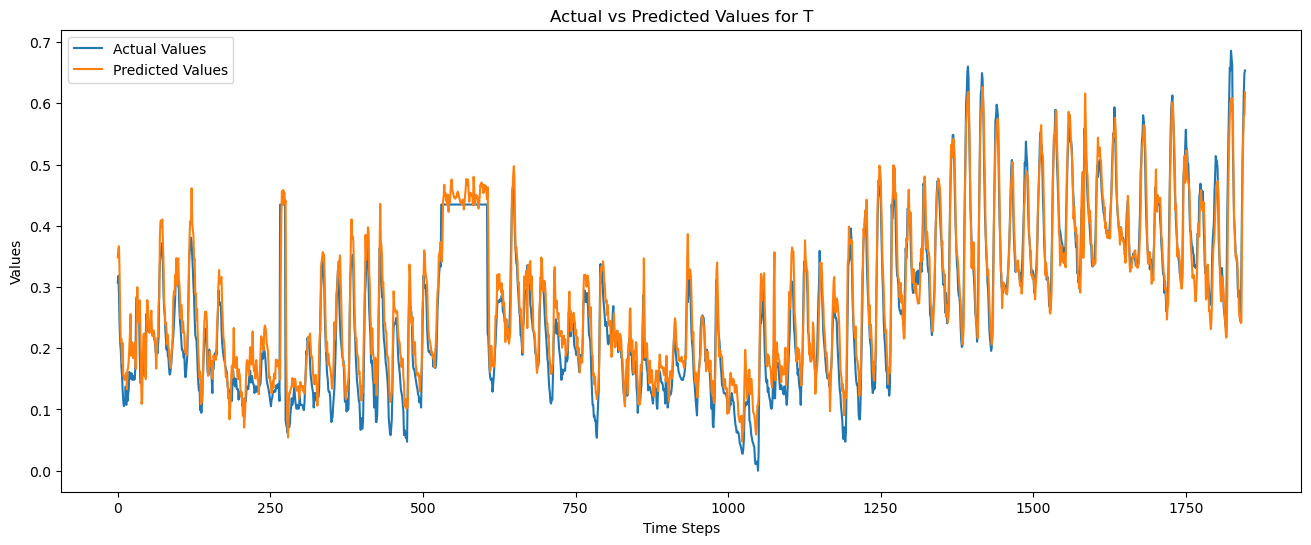

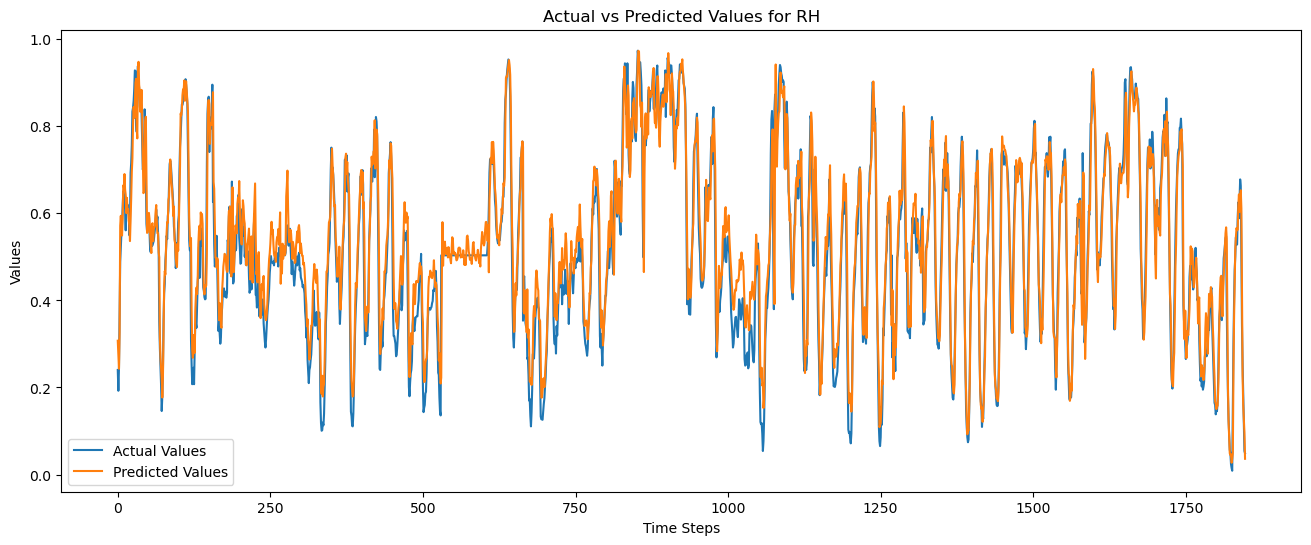

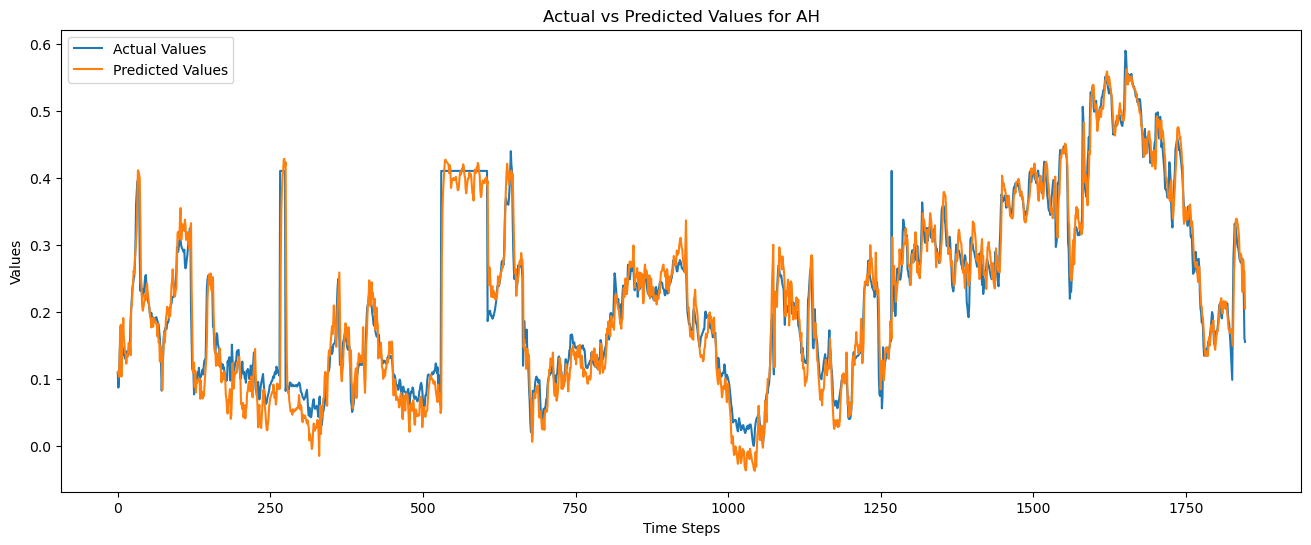

In [67]:
# Plot the predicted vs actual values for SimpleRNN
for i in range(12):
    feature_index = i  
    plt.figure(figsize=(16, 6))
    plt.plot(y_test[:, feature_index], label='Actual Values')
    plt.plot(predictions_rnn[:, feature_index], label='Predicted Values')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.title(f'Actual vs Predicted Values for {train_set.columns[feature_index + 1]} using SimpleRNN')
    plt.legend()
    plt.show()

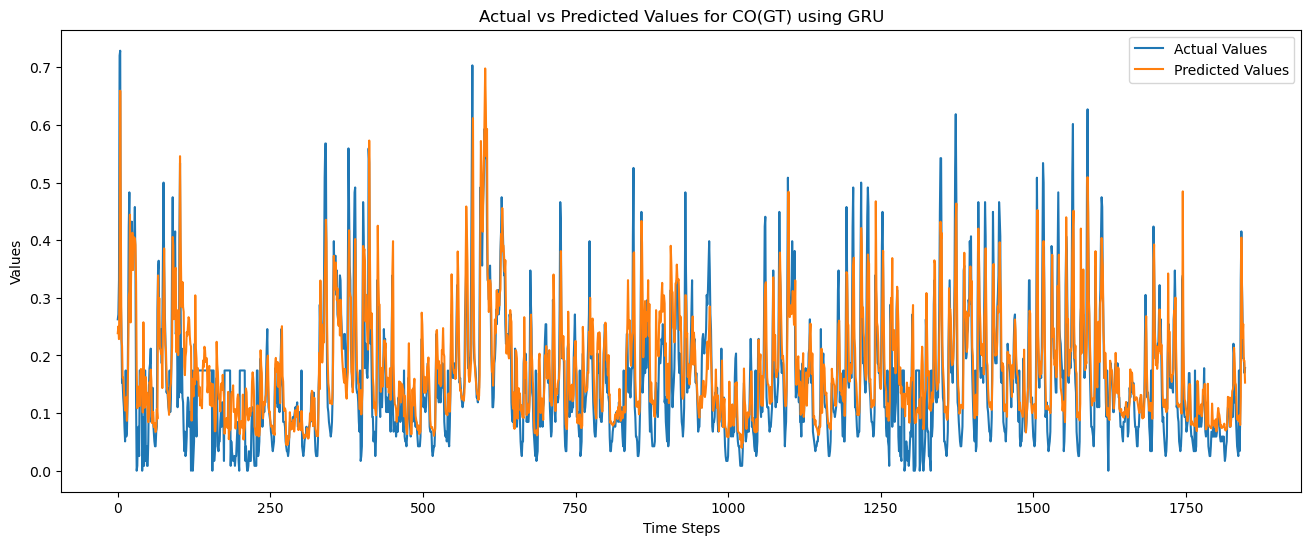

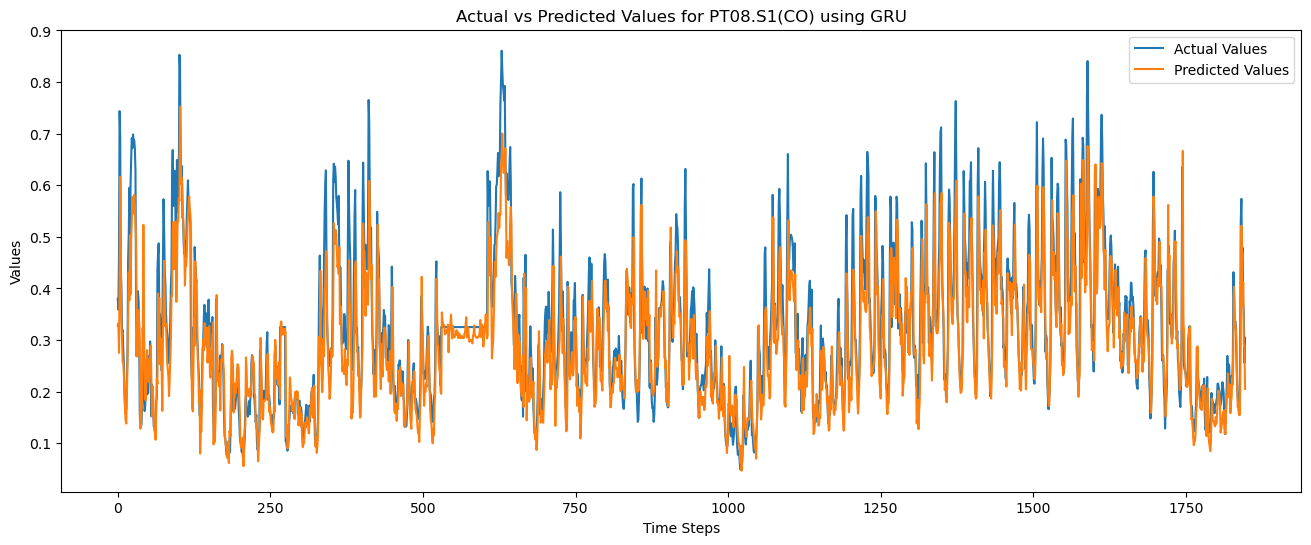

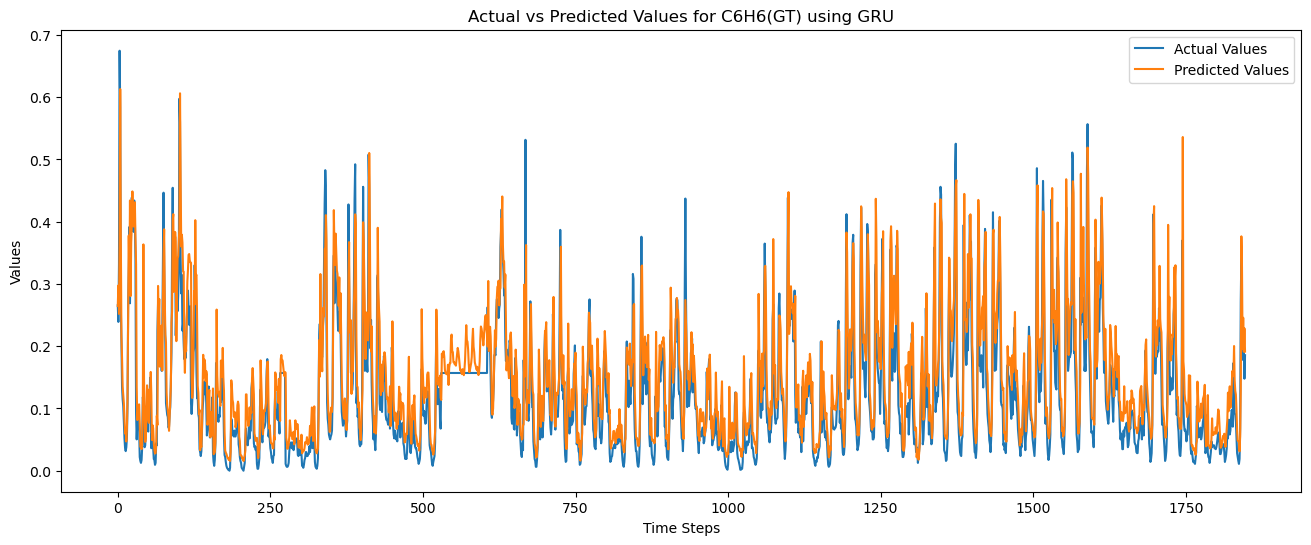

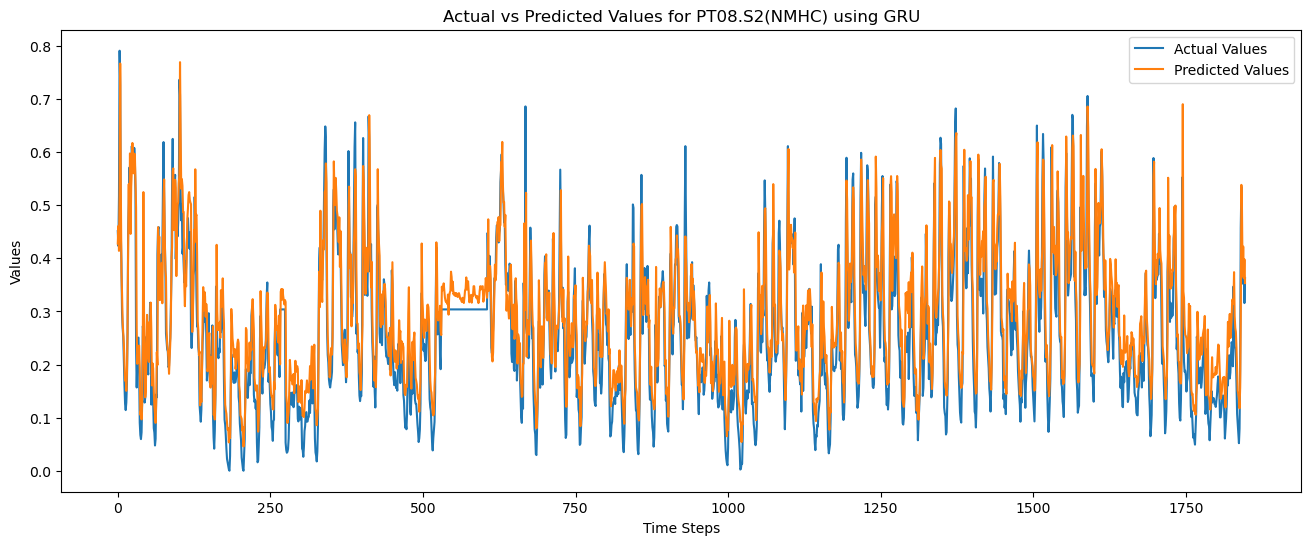

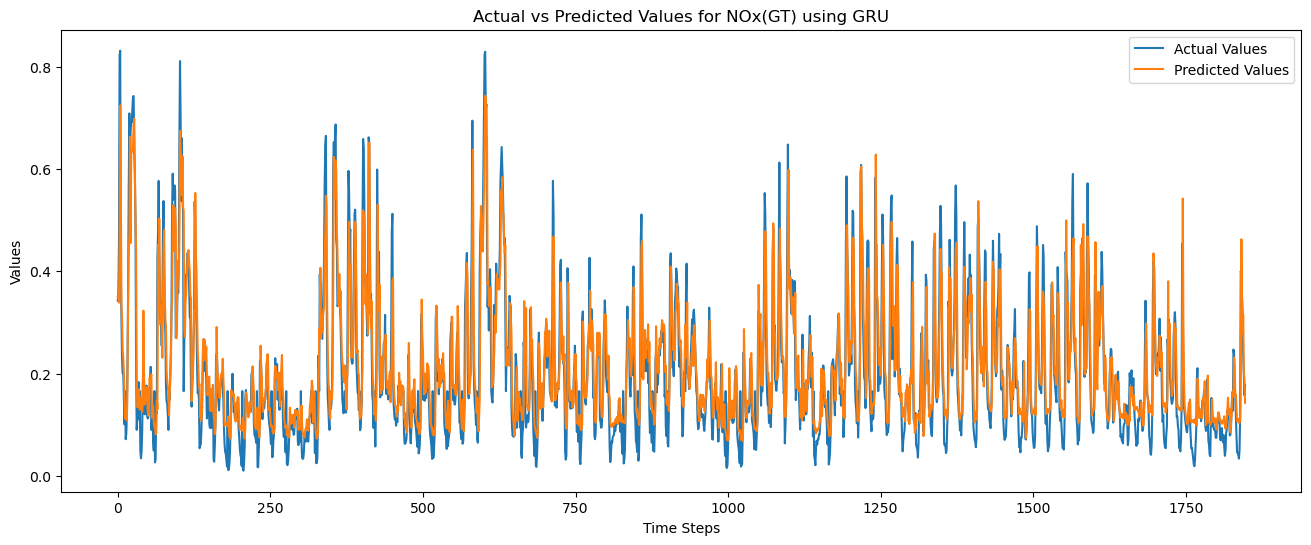

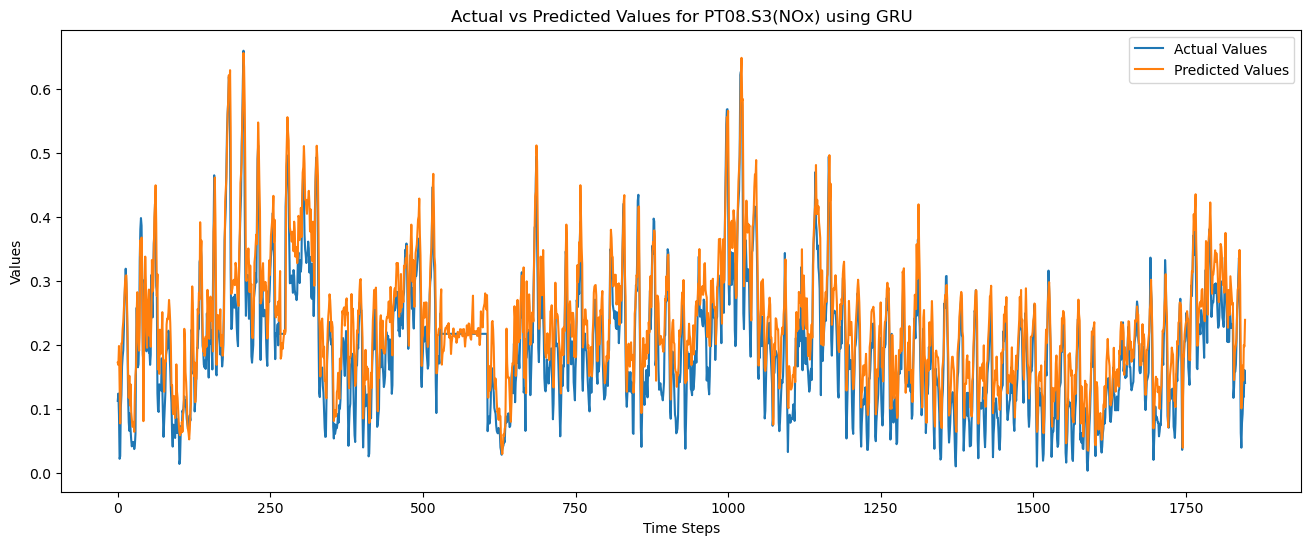

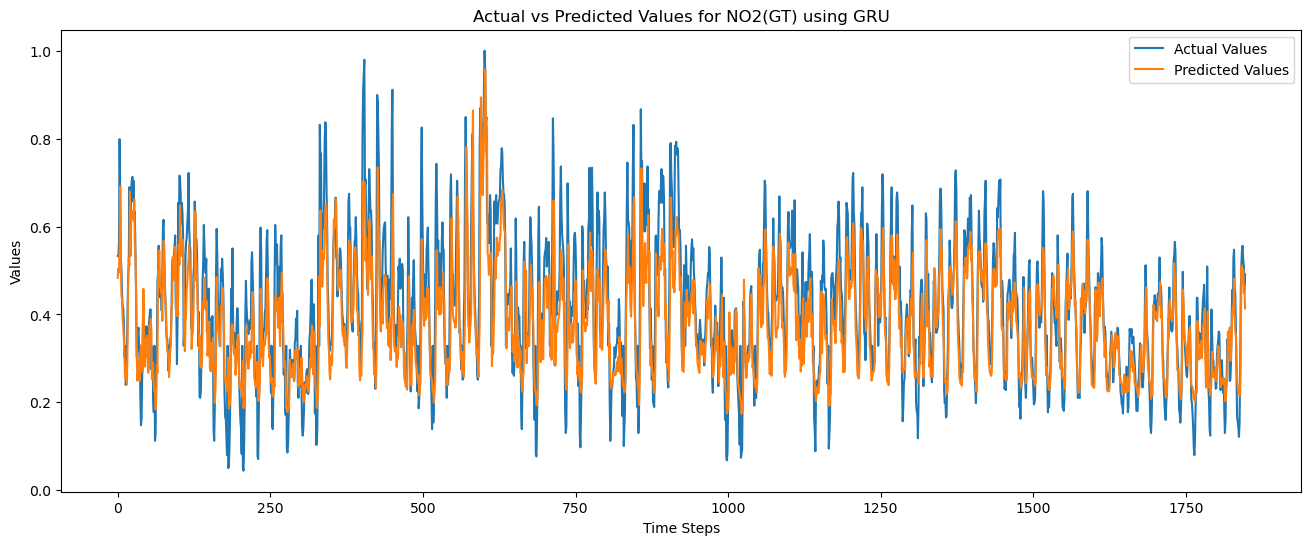

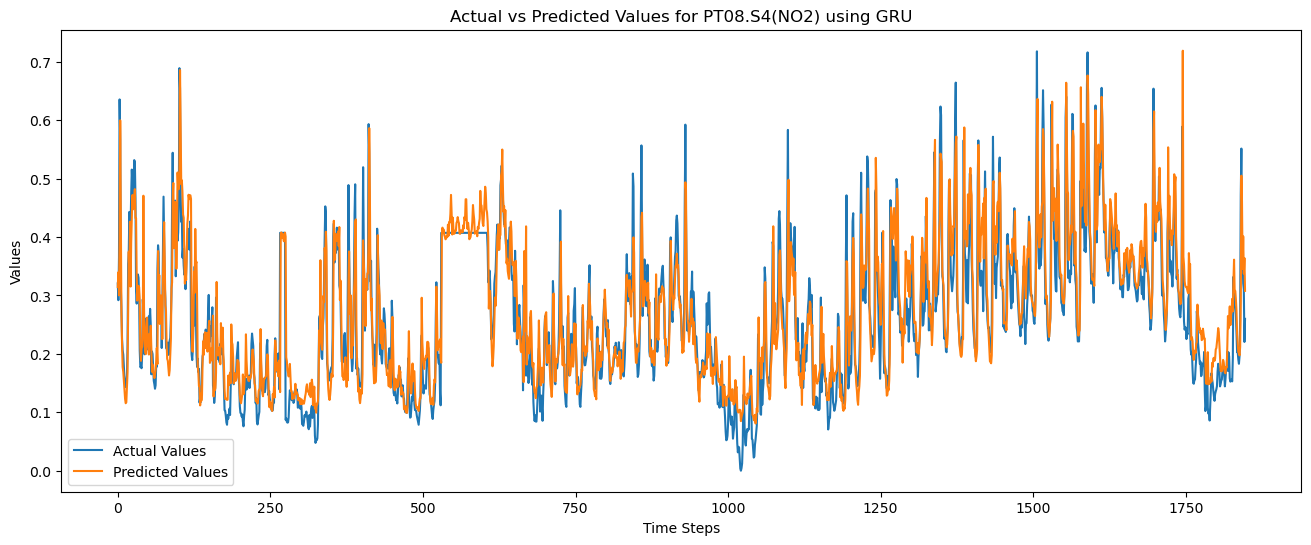

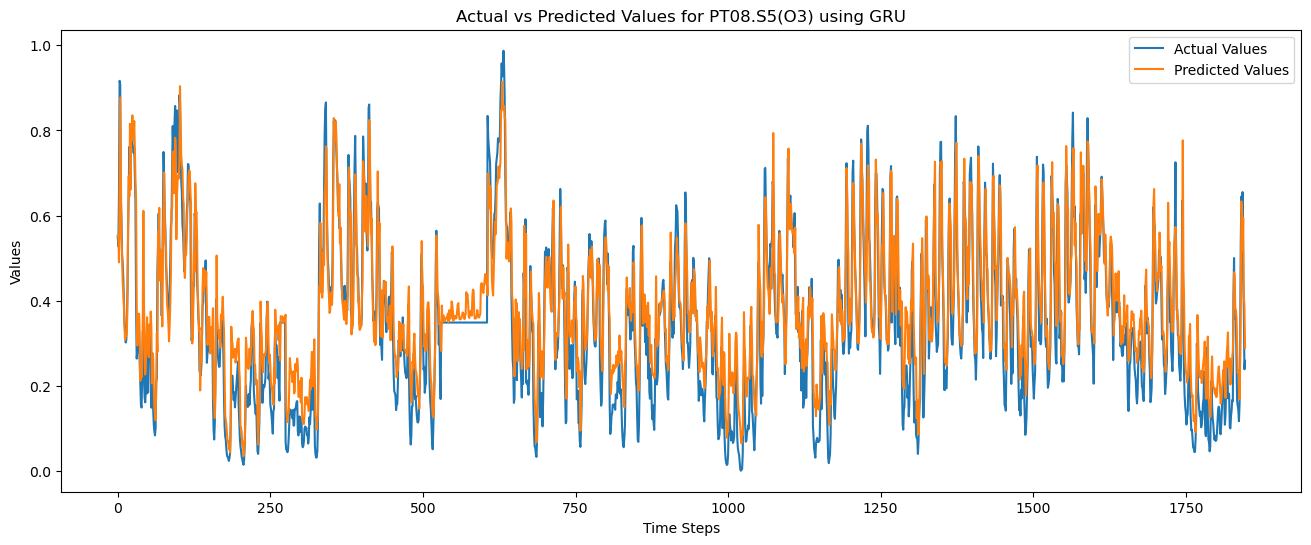

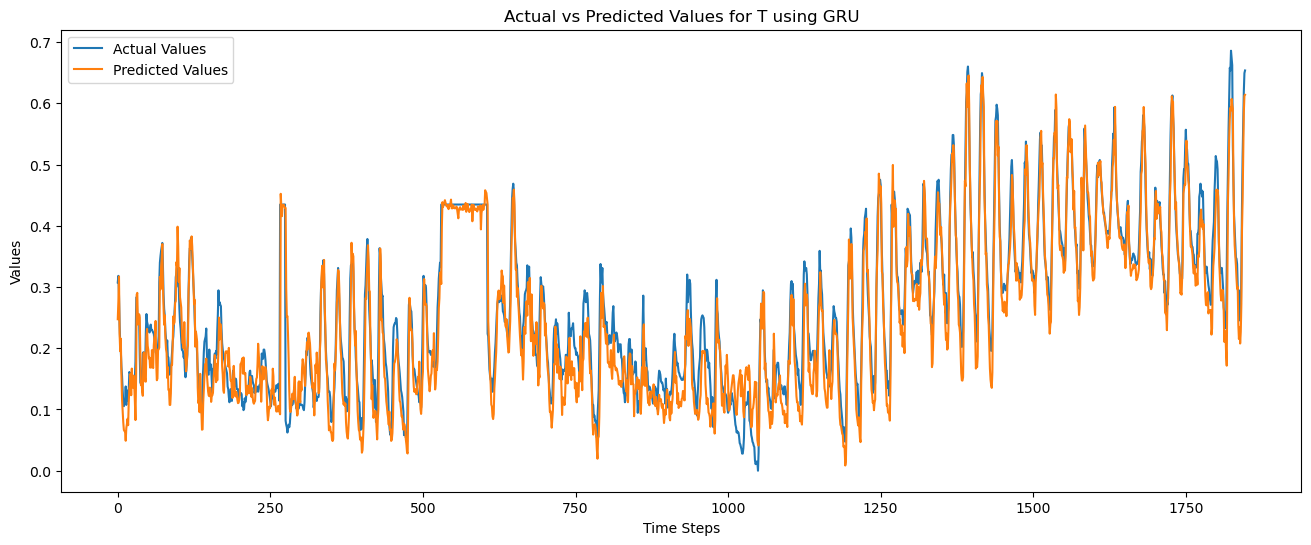

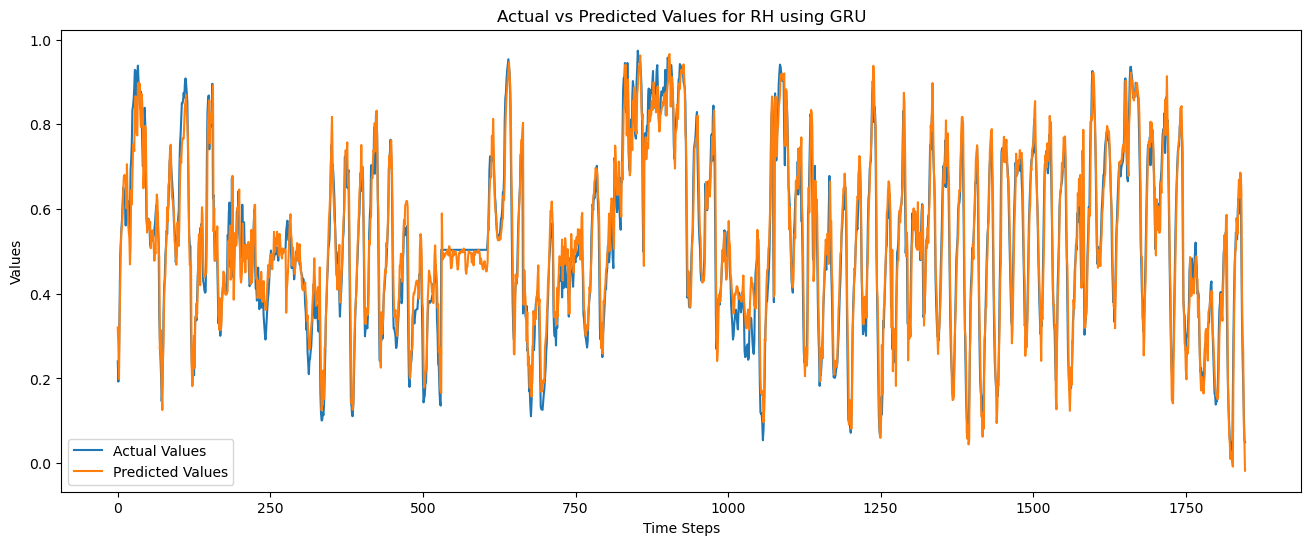

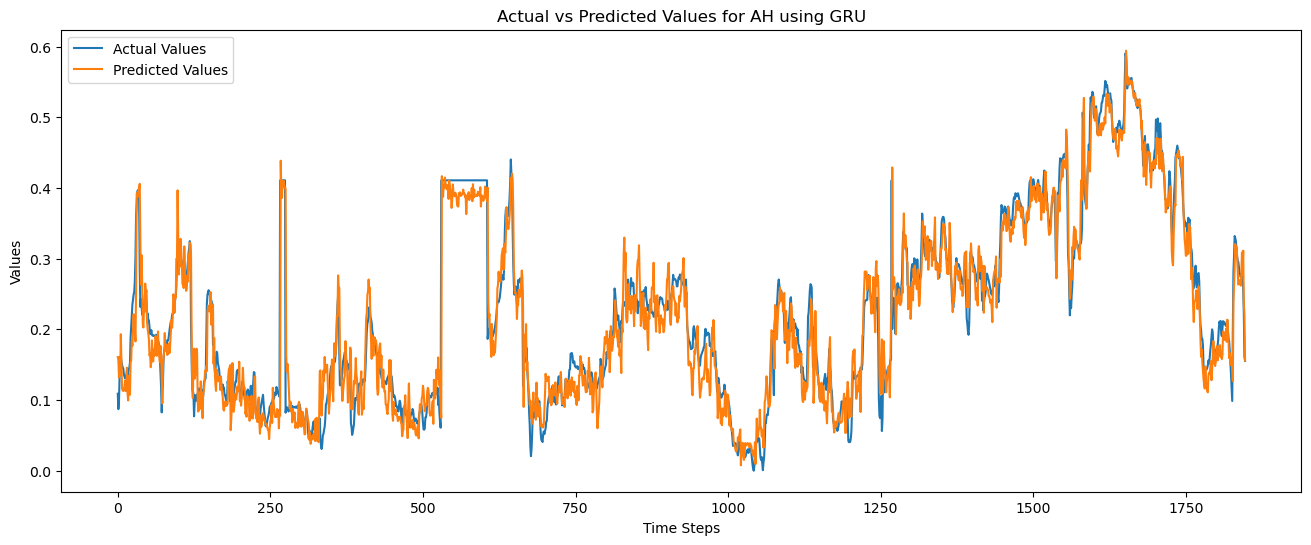

In [68]:
# Plot the predicted vs actual values for GRU.

for i in range(12):
    feature_index = i  
    plt.figure(figsize=(16, 6))
    plt.plot(y_test[:, feature_index], label='Actual Values')
    plt.plot(predictions_gru[:, feature_index], label='Predicted Values')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.title(f'Actual vs Predicted Values for {train_set.columns[feature_index + 1]} using GRU')
    plt.legend()
    plt.show()

- I have used 3 neural network models in this analysis. Simple RNN, GRU and LSTM.
- The metrics I have used to compare the 3 models are RMSE(Root Mean Square Error), MAE(Mean Absolute Error)
- Based on the above metrics, graphs, It is evident that LSTM models performs the best amongst the 3 as it has the lowest RMSE, MAE and the highest R2 value. And, viewing the graphs of the predictions its doing a good job predicting the data on the test set.
- LSTM was also preferred because of its ability to remember information over a long period of time as in our case, we are taking into account previous 24 values (24 Hrs of data) to predict the next value.
- LSTM also does a good job in handling the non-linear relationships that are present in the data.
- Next, I'll train the LSTM model on the full data and make out of sample predictions.
